Using device: cuda
Number of GPUs available: 1
GPU Name: NVIDIA GeForce MX250
Number of classes: 6
Classes: ['10_centavos', '1_boliviano', '20_centavos', '2_bolivianos', '50_centavos', '5_bolivianos']


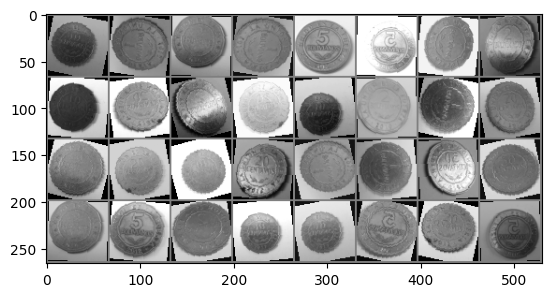

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F  # Importar torch.nn.functional como F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Configurar transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a blanco y negro
    transforms.Resize((64, 64)),  # Cambiar el tamaño de las imágenes a 64x64
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.RandomRotation(15),  # Rotación aleatoria de hasta 15 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Variación de color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar para imágenes en blanco y negro
])

# Definir rutas del dataset
train_folder = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\dataset\train"
test_folder = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\dataset\test"

# Cargar datasets
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32  # Tamaño del lote recomendado

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar el número de clases en el dataset de entrenamiento
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

# Mostrar algunas imágenes del dataset
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obtener algunas imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Cambiado a next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 canal de entrada (blanco y negro)
            nn.ReLU(),
            nn.Dropout2d(0.2)  # Dropout espacial
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2)  # Dropout espacial
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)  # Añadir dropout con probabilidad de 0.5
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Ajustar el tamaño de entrada
        self.fc2 = nn.Linear(128, num_classes)  # Número de clases

    def forward(self, x):
        x = self.pool(self.conv1(x))  # Convolución + ReLU + Pooling
        x = self.pool(self.conv2(x))  # Convolución + ReLU + Pooling
        x = x.view(-1, 64 * 16 * 16)  # Aplanar el tensor
        x = self.dropout(F.relu(self.fc1(x)))  # Capa completamente conectada + ReLU + Dropout
        x = self.fc2(x)  # Capa completamente conectada (salida)
        return x

# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Añadir weight decay

# Mover el modelo a la GPU si está disponible
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [4]:
num_epochs = 10  # Ajustar el número de epochs a 10
patience = 2  # Número de épocas para esperar antes de detener el entrenamiento si no hay mejora
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_accuracy = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # Evaluar el modelo en el conjunto de prueba
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy}%")

    # Guardar el mejor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model with Accuracy: {best_accuracy}%")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/10, Loss: 0.6859279110542719, Train Accuracy: 74.21471940476609%
Test Accuracy: 94.50919814632776%
Saved Best Model with Accuracy: 94.50919814632776%
Epoch 2/10, Loss: 0.2802397073502626, Train Accuracy: 90.12739971221002%
Test Accuracy: 96.43308524083696%
Saved Best Model with Accuracy: 96.43308524083696%
Epoch 3/10, Loss: 0.19928560059571976, Train Accuracy: 93.23693538763906%
Test Accuracy: 98.28675747788232%
Saved Best Model with Accuracy: 98.28675747788232%
Epoch 4/10, Loss: 0.15454776023486347, Train Accuracy: 94.64078896571088%
Test Accuracy: 98.59570285072321%
Saved Best Model with Accuracy: 98.59570285072321%
Epoch 5/10, Loss: 0.12128686214463762, Train Accuracy: 95.93584389148212%
Test Accuracy: 98.8203903946075%
Saved Best Model with Accuracy: 98.8203903946075%
Epoch 6/10, Loss: 0.11031656413219919, Train Accuracy: 96.22012424104166%
Test Accuracy: 98.97486308102795%
Saved Best Model with Accuracy: 98.97486308102795%
Epoch 7/10, Loss: 0.100563035274445, Train Accurac

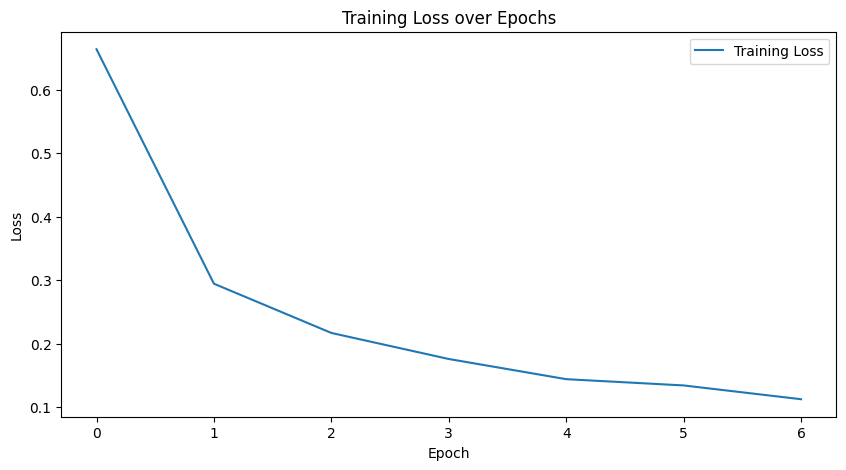

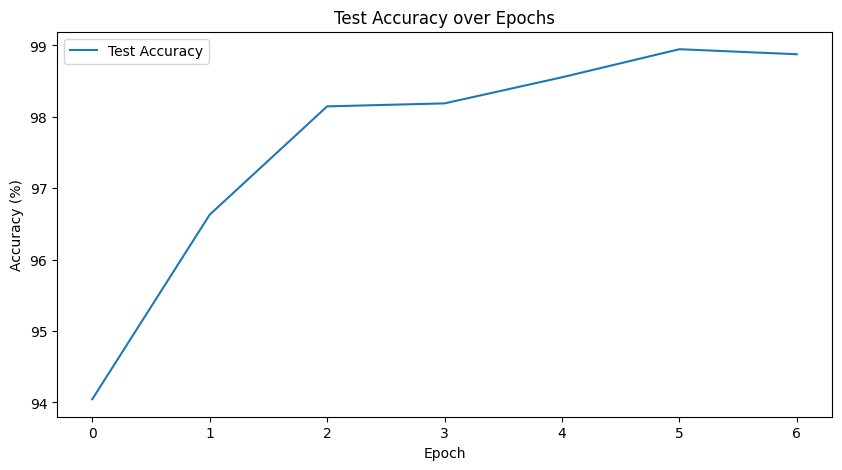

In [ ]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Graficar la precisión de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
# Cargar el mejor modelo
model = CNN(num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Mover el modelo a la GPU si está disponible
model.eval()

# Evaluar el modelo en el conjunto de prueba
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy}%")

# Reporte de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=train_dataset.classes))

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

C:\Users\cesar\AppData\Local\Temp\ipykernel_4292\3078137661.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Test Accuracy: 98.80634742311473%


In [9]:
from PIL import Image

def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Mover la imagen a la GPU si está disponible
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return train_dataset.classes[predicted.item()]

# Predecir una nueva imagen
image_path = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\prueba\50_cent.jpg"
predicted_class = predict_image(image_path, model, transform)
print(f"Predicted class: {predicted_class}")

Predicted class: 50_centavos
